In [1]:
import numpy as np
from itertools import product
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import linregress
import matplotlib.pyplot as plt
from qutip import *
from qutip.piqs import *
from qutip.cy.piqs import j_min, j_vals, m_vals
from scipy.signal import argrelextrema

from libs.helper_05_tutorial import *


In [2]:
H_latex = "$H = \Delta E J_z + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )2J_x$ "

In [348]:
def make_operators(max_bosons, parity=0, num_TLS=1):
    
    a     = tensor([destroy(max_bosons+1)] + [qeye(2) for i in range(1,num_TLS+1)])      # tensorised boson destruction operator
    J     = jspin(num_TLS, basis="uncoupled")
    Jx    = tensor(qeye(max_bosons+1), J[0])                                             # tensorised Jx operator
    Jz    = tensor(qeye(max_bosons+1), J[2])                                             # tensorised Jx operator
    J2    = tensor(qeye(max_bosons+1), J[0]*J[0] + J[1]*J[1] + J[2]*J[2])                # tensorised J^2 operator

    two_state     = Jz                                 # two state system energy operator   Jz
    bosons        = (a.dag()*a+0.5)                    # boson energy operator              𝑎†𝑎+1/2
    number        = a.dag()*a                          # boson number operator              𝑎†𝑎
    interaction   = 2*(a.dag() + a) * Jx               # interaction energy operator        2(𝑎†+𝑎)Jz  
    
    P = (1j*np.pi*(number + Jz + num_TLS/2)).expm()               # parity operator 
    
    # map from QuTiP number states to |n,±, ±, ...> states
    possible_ns = range(0, max_bosons+1)
    possible_ms = ["+","-"]
    nm_list = [(n, *ms) for n in possible_ns for ms in product(possible_ms, repeat=num_TLS)]

    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p               = np.where(P.diag()==parity)[0]
        
        two_state       = two_state.extract_states(p)
        bosons          = bosons.extract_states(p)
        number          = number.extract_states(p)
        interaction     = interaction.extract_states(p)
        J2              = J2.extract_states(p)  
        nm_list        = [nm_list[i] for i in p]
  
    
    return two_state, bosons, interaction, number, nm_list, J2

In [373]:
U=0.01
omega=1
deltaE=1

# EVEN PARITY

# make the operators
two_state, bosons, interaction, number, nm_list, J2 = make_operators(
    max_bosons=1, parity=-1, num_TLS=4)

# prepare data structure for the energy level scan
df_even = make_df_for_energy_scan("$\Delta E$", 0, 3, 201, two_state.shape[0])

# fill the data structure with eigenvalues of the Hamiltonian i.e. the energy levels
for i, row in df_even.iterrows():
    H =  row["$\Delta E$"]*two_state + omega*bosons + U*interaction
    evals, ekets = H.eigenstates()
    df_even.iloc[i,1:] = evals 

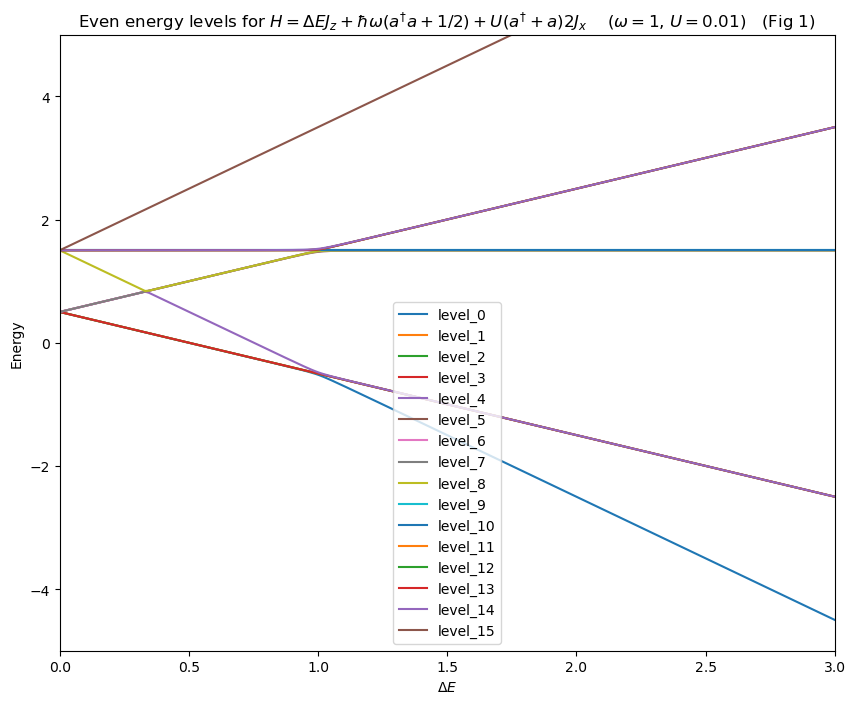

In [374]:
df_even.plot(x="$\Delta E$",ylim=[-5,5],xlim=[0,3], legend=True, 
        title=f"Even energy levels for {H_latex}   ($\omega={omega}$, $U={U}$)   (Fig 1)",
             figsize=(10,8));

plt.ylabel("Energy");

In [375]:
H = 2.5*two_state + 1*bosons + 0.01*interaction

In [376]:
bra_labels, ket_labels = make_braket_labels(nm_list)

In [377]:
nm_list

[(0, '+', '+', '+', '-'),
 (0, '+', '+', '-', '+'),
 (0, '+', '-', '+', '+'),
 (0, '+', '-', '-', '-'),
 (0, '-', '+', '+', '+'),
 (0, '-', '+', '-', '-'),
 (0, '-', '-', '+', '-'),
 (0, '-', '-', '-', '+'),
 (1, '+', '+', '+', '+'),
 (1, '+', '+', '-', '-'),
 (1, '+', '-', '+', '-'),
 (1, '+', '-', '-', '+'),
 (1, '-', '+', '+', '-'),
 (1, '-', '+', '-', '+'),
 (1, '-', '-', '+', '+'),
 (1, '-', '-', '-', '-')]

In [385]:
psi0 = basis(len(nm_list), 3)
times = np.linspace(0.0, 60000.0, 10000)
P, psi = simulate(H, psi0, times)

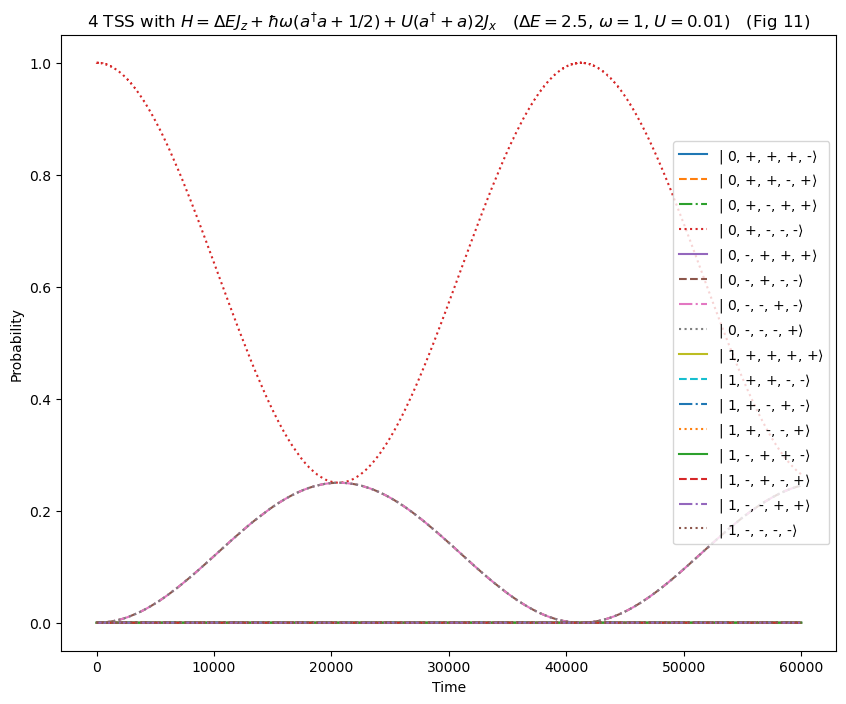

In [386]:
plot_prob(P ,times, ket_labels)
plt.title(f"4 TSS with {H_latex}  ($\Delta E = 2.5$, $\omega=1$, $U=0.01$)   (Fig 11)");

In [387]:
psi0 = basis(len(nm_list), 3) + basis(len(nm_list), 5)
psi0 = psi0.unit()
times = np.linspace(0.0, 60000.0, 10000)
P, psi = simulate(H, psi0, times)

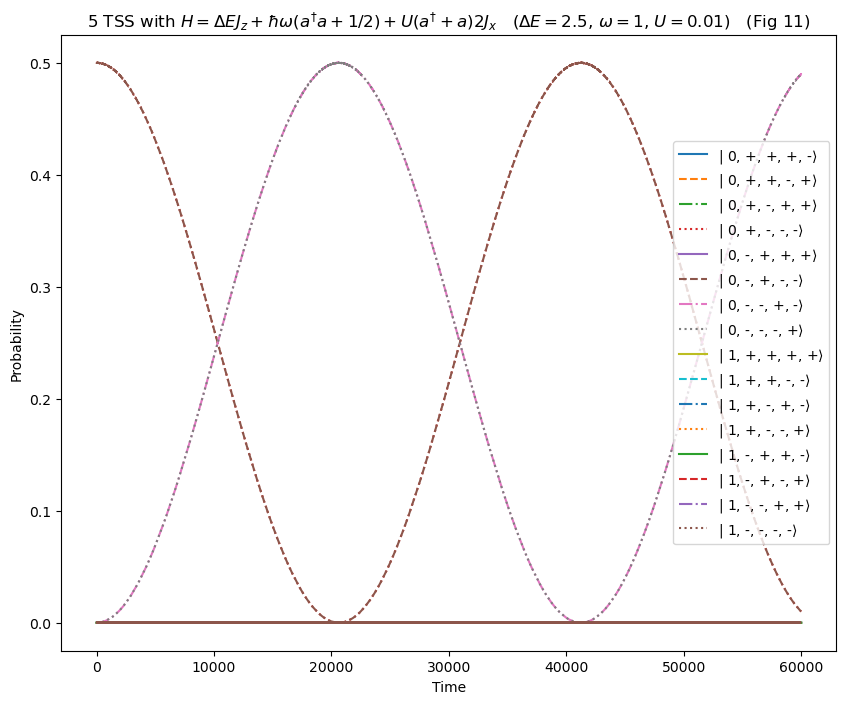

In [388]:
plot_prob(P ,times, ket_labels)
plt.title(f"5 TSS with {H_latex}  ($\Delta E = 2.5$, $\omega=1$, $U=0.01$)   (Fig 11)");

In [389]:
def make_operators_JAB(max_bosons, parity=0, num_TLS_A=1, num_TLS_B=1):
    
    JA     = jmat(0.5) if num_TLS_A==1 else jmat(num_TLS_A/2)
    JB     = jmat(0.5) if num_TLS_B==1 else jmat(num_TLS_B/2)
    JxA   = tensor(qeye(max_bosons+1), JA[0], qeye(JB[0].dims[0][0]))       # tensorised J𝑥 operator 
    JxB   = tensor(qeye(max_bosons+1), qeye(JA[0].dims[0][0]), JB[0])       # tensorised J𝑥 operator 
    JzA   = tensor(qeye(max_bosons+1), JA[2], qeye(JB[0].dims[0][0]))       # tensorised Jz operator 
    JzB   = tensor(qeye(max_bosons+1), qeye(JA[0].dims[0][0]), JB[2])       # tensorised Jz operator 
    a     = tensor(destroy(max_bosons+1), qeye(JA[0].dims[0][0]), qeye(JB[0].dims[0][0]))     # tensorised boson destruction operator

    two_state_A     = JzA                                 # two state system energy operator   Jz
    two_state_B     = JzB                                 # two state system energy operator   Jz
    bosons        = (a.dag()*a+0.5)                    # boson energy operator              𝑎†𝑎+1/2
    number        = a.dag()*a                          # boson number operator              𝑎†𝑎
    interaction_A   = 2*(a.dag() + a) * JxA               # interaction energy operator        2(𝑎†+𝑎)Jz  
    interaction_B   = 2*(a.dag() + a) * JxB               # interaction energy operator        2(𝑎†+𝑎)Jz  
    
    P = (1j*np.pi*(number + JzA + JzB + (num_TLS_A+num_TLS_B)/2)).expm()               # parity operator 

    
    # map from QuTiP number states to |n,±, ±, ...> states
    possible_ns = range(0, max_bosons+1)
    possible_ms_A = range(num_TLS_A, -1,-1)
    possible_ms_B = range(num_TLS_B, -1,-1)
    nm_list = [(n,m1,m2) for (n,m1,m2) in product(possible_ns, possible_ms_A, possible_ms_B)]

    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p               = np.where(P.diag()==parity)[0]
        
        two_state_A       = two_state_A.extract_states(p)
        two_state_B       = two_state_B.extract_states(p)
        bosons          = bosons.extract_states(p)
        number          = number.extract_states(p)
        interaction_A     = interaction_A.extract_states(p)
        interaction_B     = interaction_B.extract_states(p)
        nm_list        = [nm_list[i] for i in p]
  
    return two_state_A, two_state_B, bosons, interaction_A, interaction_B, number, nm_list

1000 atoms

100 of which are in a superposition in which N of those 100 are excited

how fast do those N excitations move into the other 900 atoms

Grpoup A = 100 (Fe57)
GRoup B  = 900 (Fe57)

Hyothetical scneario
Laser spot on 100 atoms and result is 50 are excited. In what situation do the 50 excitations get spread (delocatlised?) across the 100, i.e. how do the 100 atoms become entagnled.

Q for matt in the future - WTF is entanglement?!


volume of deteron pairs as a delocalised excited state of helium4?

Null reacton:
Group A = deuteron pairs and He4
Group B = he4



In [406]:
two_state_A, two_state_B, bosons, interaction_A, interaction_B, number, nm_list = make_operators_JAB(max_bosons=2, parity=-1, num_TLS_A=10, num_TLS_B=10)


In [407]:
U=0.01
omega=1
deltaE=2.5

In [408]:
H = deltaE*two_state_A + deltaE*two_state_B + omega*bosons + U*interaction_A + U*interaction_B


In [ ]:
times = np.linspace(0.0, 60000.0, 10000)

In [409]:
psi0 = basis(len(nm_list), nm_list.index((0,5,0)))
result = mesolve(H, psi0, times, [], [two_state_A, two_state_B, number])

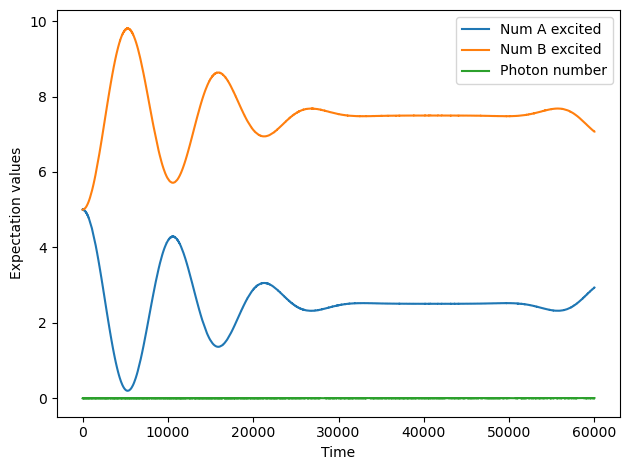

In [411]:
plt.figure()

plt.xlabel("Time")
plt.ylabel("Expectation values")
plt.plot(times, result.expect[0] + 10/2, label="Num A excited")
plt.plot(times, result.expect[1] + 20/2, label="Num B excited")
plt.plot(times, result.expect[2], label="Photon number")
plt.legend()


plt.tight_layout()
plt.show()

In [404]:
nm_list.index((0,5,0))

62

In [396]:
nm_list[152]

(0, 5, 0)

In [306]:
U=0.05
omega=1
deltaE=1


two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nm_list = make_operators_JAB(max_bosons=1, parity=0, num_TLS_A=1, num_TLS_B=4)

# prepare data structure for the energy level scan
df_even = make_df_for_energy_scan("$\Delta E$", 0, 3, 201, two_state_1.shape[0])

for i, row in df_even.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + omega*bosons + U*interaction_1 + U*interaction_2
    evals, ekets = H.eigenstates()
    df_even.iloc[i,1:] = evals 

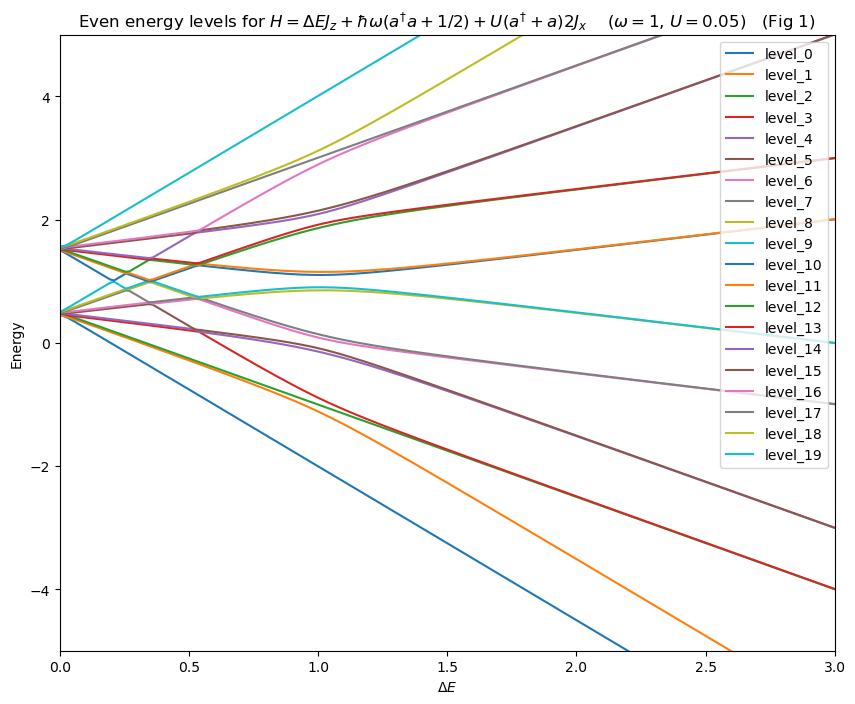

In [307]:
df_even.plot(x="$\Delta E$",ylim=[-5,5],xlim=[0,3], legend=True, 
        title=f"Even energy levels for {H_latex}   ($\omega={omega}$, $U={U}$)   (Fig 1)",
             figsize=(10,8));

plt.ylabel("Energy");
